# Лабораторная работа №4

ФИО:  **Мньшов Алексей Сергеевич**
Группа: **БИВТ-20-3**

Отправлять можно следующими способами (**обязательно указать свое ФИО и группу в каком-либо виде**):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
2. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
3. Отправить заполненный ноутбук мне в тг @l3lush. 

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)


**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):
1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
2. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
3. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
4. Оформить датасет из шага 3 в Dataloader.
5. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
6. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть [тут](https://pytorch.org/vision/stable/models.html)).
7. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**  
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.  

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)  
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

In [124]:
import torch
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from PIL import Image
import numpy as np

In [3]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

In [120]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [116]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_paths = []
        self.labels = []

        for label in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label)
            for img_name in os.listdir(label_dir):
                img_path = os.path.join(label_dir, img_name)
                self.img_paths.append(img_path)
                self.labels.append(int(label))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [121]:
dataset = DiabeticRetinopathyDataset('./data/', transform=data_transforms)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Датасет Diabetic Retinopathy Resized & Arranged содержит изображения сетчатки глаза, полученные с помощью фотографий глаз пациентов, страдающих диабетической ретинопатией. Датасет содержит 5 классов, соответствующих различным степеням развития заболевания: от отсутствия (класс 0) до сильной стадии (класс 4). Каждое изображение имеет размер 512x512 пикселей и представлено в формате JPEG.

Задача поставленная перед нами - классификация изображений на 5 классов, соответствующих различным степеням развития диабетической ретинопатии.

Ниже представлен экземпляр из датасета с применённой аугументацией

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


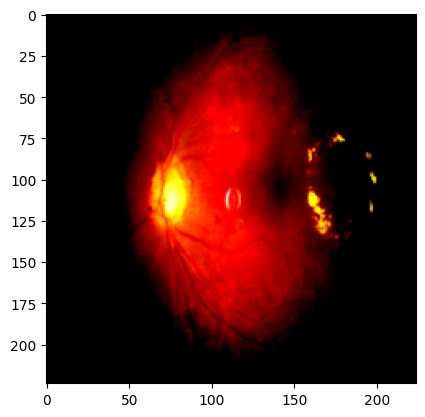

In [123]:
plt.imshow(np.array(dataset[0][0]).transpose(1,2,0))

Архитектура собственной нейронной сети

In [47]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(25088, 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

Модель составленная при помощи Transfer Learning, для извлечения фичей была использована предобученная модель RESNET18

In [126]:
model_transfer = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_transfer.fc.in_features
model_transfer = model_transfer.to(device)
for param in model_transfer.parameters():
    param.requires_grad = False
model_transfer.fc = nn.Sequential(
               nn.Linear(num_ftrs, 32),
               nn.ReLU(inplace=True),
               nn.Linear(32, 5)).to(device)

In [48]:
Net = ConvNet(5).to(device)

In [19]:
optimizer = torch.optim.SGD(params=Net.parameters(), lr=0.0001)
optimizer_transfer = torch.optim.SGD(params=model_transfer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

Обучение первой модели

In [51]:
num_epochs = 10

for epoch in range(num_epochs):
    Net.train()
    train_loss = 0
    train_correct = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = Net(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += accuracy_score(labels.cpu(), predictions.cpu())
    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / len(train_dataset)
    print(f"Epoch {epoch} | train loss {train_loss} | train accuracy {train_acc}")
    
    Net.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = Net(images.to(device))
            loss = criterion(outputs, labels.to(device))
            test_loss += loss.item() *images.size(0)
            _, predictions = torch.max(outputs, 1)
            test_correct += accuracy_score(labels.cpu(), predictions.cpu())
    test_loss = test_loss / len(test_dataset)
    test_acc = test_correct / len(test_dataset)
    print(f"Epoch {epoch} | test loss {test_loss} | test accuracy {test_acc}")


Epoch 0 | train loss 1.5942225665299494 | train accuracy 0.014320507117437722
Epoch 0 | test loss 1.5943573517165495 | test accuracy 0.01874535455609324
Epoch 1 | train loss 1.594303394416049 | train accuracy 0.014214857651245551
Epoch 1 | test loss 1.5943450335250973 | test accuracy 0.01864404434323307
Epoch 2 | train loss 1.5943539815610839 | train accuracy 0.014231539145907473
Epoch 2 | test loss 1.59435685183837 | test accuracy 0.018704336274788878
Epoch 3 | train loss 1.5942320859474644 | train accuracy 0.01422709074733096
Epoch 3 | test loss 1.594336964145468 | test accuracy 0.01865096308947718
Epoch 4 | train loss 1.5943107754989028 | train accuracy 0.014210409252669039
Epoch 4 | test loss 1.5943455244786984 | test accuracy 0.018771052756428503
Epoch 5 | train loss 1.5941764182976557 | train accuracy 0.014447286476868328
Epoch 5 | test loss 1.594352869644078 | test accuracy 0.01856398456526552
Epoch 6 | train loss 1.5941974263174254 | train accuracy 0.01435053380782918
Epoch 6 |

Обучение второй модели

In [11]:
num_epochs = 10

for epoch in range(num_epochs):
    model_transfer.train()
    train_loss = 0
    train_correct = 0
    for images, labels in train_loader:
        optimizer_transfer.zero_grad()
        outputs = model_transfer(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer_transfer.step()
        train_loss += loss.item() * images.size(0)
        _, predictions = torch.max(outputs, 1)
        train_correct += torch.sum(predictions == labels.to(device).data)
    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct.double() / len(train_dataset)
    print(f"Epoch{epoch} | train loss {train_loss} | train accuracy {train_acc}")
    
    model_transfer.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model_transfer(images.to(device))
            loss = criterion(outputs, labels.to(device))
            test_loss += loss.item() *images.size(0)
            _, predictions = torch.max(outputs, 1)
            test_correct += torch.sum(predictions == labels.to(device).data)
    test_loss = test_loss / len(test_dataset)
    test_acc = test_correct.double() / len(test_dataset)
    print(f"Epoch{epoch} | test loss {test_loss} | test accuracy {test_acc}")


Epoch0 | train loss 0.9120912523201776 | train accuracy 0.7245195729537366
Epoch0 | test loss 0.8656061865853816 | test accuracy 0.7312838030173641
Epoch1 | train loss 0.8605408530133475 | train accuracy 0.7356583629893239
Epoch1 | test loss 0.8547778762781548 | test accuracy 0.7312838030173641
Epoch2 | train loss 0.8482718182119187 | train accuracy 0.7356583629893239
Epoch2 | test loss 0.845869278537898 | test accuracy 0.7312838030173641
Epoch3 | train loss 0.8399254633777931 | train accuracy 0.7356583629893239
Epoch3 | test loss 0.8341547214608229 | test accuracy 0.7312838030173641
Epoch4 | train loss 0.8306204193257777 | train accuracy 0.7357651245551601
Epoch4 | test loss 0.8297262385025209 | test accuracy 0.7312838030173641
Epoch5 | train loss 0.8249377789785853 | train accuracy 0.7357651245551601
Epoch5 | test loss 0.8223822402404375 | test accuracy 0.7312838030173641
Epoch6 | train loss 0.8173800380034804 | train accuracy 0.7356939501779359
Epoch6 | test loss 0.8171819698053855 

In [127]:
model_transfer.eval()
Net.eval()
y_true = []
y_pred_conv = []
y_pred_transfer = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs_conv = Net(images.to(device))
        outputs_transfer = model_transfer(images.to(device))
        _, predictions_conv = torch.max(outputs_conv, 1)
        _, predictions_transfer = torch.max(outputs_transfer, 1)
        y_true.extend(labels.to(device).tolist())
        y_pred_conv.extend(predictions_conv.tolist())
        y_pred_transfer.extend(predictions_transfer.tolist())
        

accuracy_transfer = accuracy_score(y_true, y_pred_transfer)
precision_transfer = precision_score(y_true, y_pred_transfer, average='macro', zero_division=1)
recall_transfer = recall_score(y_true, y_pred_transfer, average='macro', zero_division=1)
f1_transfer = f1_score(y_true, y_pred_transfer, average='macro', zero_division=1)

accuracy_conv = accuracy_score(y_true, y_pred_conv)
precision_conv = precision_score(y_true, y_pred_conv, average='macro', zero_division=1)
recall_conv = recall_score(y_true, y_pred_conv, average='macro', zero_division=1)
f1_conv = f1_score(y_true, y_pred_conv, average='macro', zero_division=1)

print('Transfer: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 score: {:.4f} Conv: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1 score: {:.4f}'.format(
    accuracy_transfer, precision_transfer, recall_transfer, f1_transfer, accuracy_conv, precision_conv, recall_conv, f1_conv))

Transfer: Accuracy: 0.0719, Precision: 0.1716, Recall: 0.1949, F1 score: 0.0332 Conv: Accuracy: 0.6042, Precision: 0.7598, Recall: 0.1970, F1 score: 0.1725


По результатам исследования на небольшом количестве эпох результаты 2 моделей сильне не отличаются, хотя accuracy у модели с transfer learning выше, эта метрика не всегда говорит о хорошем качестве модели,а вот показатель f1 меры у них одинаковый. Чтобы добиться хороших результатов моделей необходимо повысить число эпох.